# Transforming Data:

In [58]:
# Necessary Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Modeling Libraries:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss

In [59]:
# Load the datasets of choice, can change the weeks input
inputs = pd.read_csv('C:\\Users\\jrzem\\Downloads\\NFL-Big-Data-Bowl-2026-Analytics-Challenge\\Kaggle Data\\train\\input_2023_w01.csv')
outputs = pd.read_csv('C:\\Users\\jrzem\\Downloads\\NFL-Big-Data-Bowl-2026-Analytics-Challenge\\Kaggle Data\\train\\output_2023_w01.csv')
supp = pd.read_csv('C:\\Users\\jrzem\\Downloads\\NFL-Big-Data-Bowl-2026-Analytics-Challenge\\Kaggle Data\\supplementary_data.csv')

# Distance Modeling:

### Identify Targeted Receivers and Defenders:

In [60]:
# Restrict to targeted throws only
targets = inputs[inputs["player_role"].str.contains("Targeted Receiver", na=False)].copy()

# Throw frame = last input frame for that player/play
targets_throw = (
    targets
    .sort_values(["game_id", "play_id", "nfl_id", "frame_id"])
    .groupby(["game_id", "play_id", "nfl_id"])
    .tail(1)
    .rename(columns={"frame_id": "throw_frame"})
)

# Get all coverage defenders at throw time (same play & frame)
defenders_throw = (
    inputs[inputs["player_role"].str.contains("Defensive Coverage", na=False)]
    .merge(
        targets_throw[["game_id", "play_id", "throw_frame"]],
        on=["game_id", "play_id"],
        how="inner"
    )
)

defenders_throw = defenders_throw[defenders_throw["frame_id"] == defenders_throw["throw_frame"]]

# Join with supplementary (play-level context)
plays = (
    targets_throw
    .merge(
        supp,
        on=["game_id", "play_id"],
        how="left",
        suffixes=("", "_supp")
    )
)

### Use Euclidean Distance:

In [61]:
FRAME_RATE = 10.0  # NFL tracking is 10 Hz → 0.1s per frame
DT = 1.0 / FRAME_RATE

def distance_to_ball(df, x_ball_col="ball_land_x", y_ball_col="ball_land_y"):
    return np.sqrt(
        (df["x"] - df[x_ball_col])**2 + 
        (df["y"] - df[y_ball_col])**2
    )

At the throw frame, assume each player runs straight toward the landing point at their current scalar speed s (from input). Ignore acceleration/orientation for a first pass:

In [62]:
V_MIN = 1.0  # to avoid dividing by ~0; tune

# Compute receiver time-to-arrive at release
targets_throw["dist_to_ball_release"] = distance_to_ball(targets_throw)
targets_throw["T_WR_release"] = (
    targets_throw["dist_to_ball_release"] / 
    targets_throw["s"].clip(lower=V_MIN)
)

# Compute defenders' time-to-arrive at release
defenders_throw["dist_to_ball_release"] = distance_to_ball(defenders_throw)
defenders_throw["T_def_release"] = (
    defenders_throw["dist_to_ball_release"] /
    defenders_throw["s"].clip(lower=V_MIN)
)

# Aggregate to per-throw metrics
def_race = (
    defenders_throw
    .groupby(["game_id", "play_id"])
    .agg(
        T_def_min_release=("T_def_release", "min"),
        T_def_mean_release=("T_def_release", "mean"),
        n_defenders_release=("nfl_id", "nunique")
    )
    .reset_index()
)

race_release = (
    targets_throw
    .merge(def_race, on=["game_id", "play_id"], how="left")
)

race_release["deltaT_release"] = (
    race_release["T_def_min_release"] - race_release["T_WR_release"]
)

deltaT_release > 0: WR is projected to get there first.

deltaT_release < 0: some defender is projected to beat him there.

In [63]:
R_THRESH = 3.0  # yards, within “catchable” radius

# 1. Tag WR vs defenders using input info
wr_ids = targets_throw[["game_id", "play_id", "nfl_id"]].copy()
wr_ids["is_wr"] = 1

def_ids = defenders_throw[["game_id", "play_id", "nfl_id"]].copy()
def_ids["is_wr"] = 0

role_tags = pd.concat([wr_ids, def_ids], ignore_index=True).drop_duplicates()

# 2. Join role tags into output tracking
output = outputs.merge(role_tags, on=["game_id", "play_id", "nfl_id"], how="inner")

# 3. Compute distance to ball for all tagged players
# Need ball_land_x/y per (game_id, play_id, nfl_id) from input (they’re identical across players)
ball_land = (
    inputs[["game_id", "play_id", "nfl_id", "ball_land_x", "ball_land_y"]]
    .drop_duplicates(["game_id", "play_id", "nfl_id"])
)

output = output.merge(
    ball_land[["game_id", "play_id", "nfl_id", "ball_land_x", "ball_land_y"]],
    on=["game_id", "play_id", "nfl_id"],
    how="left"
)

output["dist_to_ball"] = distance_to_ball(output)

# 4. First-arrival frame per player
arrivals = (
    output[output["dist_to_ball"] <= R_THRESH]
    .sort_values(["game_id", "play_id", "nfl_id", "frame_id"])
    .groupby(["game_id", "play_id", "nfl_id"])
    .agg(first_arrival_frame=("frame_id", "first"))
    .reset_index()
)

arrivals["T_arrive"] = arrivals["first_arrival_frame"] * DT  # relative to output frame 0

# 5. Aggregate to WR vs nearest defender per play
arrivals = arrivals.merge(role_tags, on=["game_id", "play_id", "nfl_id"], how="left")

wr_arrivals = arrivals[arrivals["is_wr"] == 1].rename(columns={"T_arrive": "T_WR_emp"})
def_arrivals = (
    arrivals[arrivals["is_wr"] == 0]
    .groupby(["game_id", "play_id"])
    .agg(T_def_min_emp=("T_arrive", "min"))
    .reset_index()
)

race_emp = (
    wr_arrivals[["game_id", "play_id", "T_WR_emp"]]
    .merge(def_arrivals, on=["game_id", "play_id"], how="left")
)

race_emp["deltaT_empirical"] = race_emp["T_def_min_emp"] - race_emp["T_WR_emp"]

# Probability Modeling:

#### Building a completion probability model
Now build a per-play, per-target row with:

- Response:
  - is_complete = (pass_result == "C")
- Race features:
  - deltaT_release, deltaT_empirical
  - T_WR_release, T_def_min_release
  - T_WR_emp, T_def_min_emp
  - optional: distance-based features (min separation, etc.)
- Context features from supplementary:
  - pass_length, yards_to_go, down, quarter, expected_points
  - team_coverage_man_zone, team_coverage_type
  - pass_location_type, dropback_type
  - plus team & game state variables.

In [64]:
# Basic binary label
plays["is_complete"] = (plays["pass_result"] == "C").astype(int)

# Merge race features
model_df = (
    plays
    .merge(race_release[[
        "game_id", "play_id", "nfl_id",
        "T_WR_release", "T_def_min_release", "deltaT_release"
    ]], on=["game_id", "play_id", "nfl_id"], how="left")
    .merge(race_emp[[
        "game_id", "play_id",
        "T_WR_emp", "T_def_min_emp", "deltaT_empirical"
    ]], on=["game_id", "play_id"], how="left")
)

# Optional: filter to canonical pass types (exclude sacks, scrambles, penalties, etc.)
model_df = model_df[model_df["play_nullified_by_penalty"] != "Y"]
model_df = model_df[model_df["pass_result"].isin(["C", "I", "IN"])]

### Preparing Data:
- Start with logistic regression to see whether ΔT is meaningful:
- Have to deal with instances where players aren't within R-Threshold of the ball.

In [65]:
# How many model_df rows, how many have deltaT_empirical
print("Total plays:", len(model_df))
print("Non-null deltaT_empirical:", model_df["deltaT_empirical"].notna().sum())

# Check pass_result distribution for null vs non-null
tmp = (
    model_df
    .assign(has_emp=model_df["deltaT_empirical"].notna())
    .groupby(["has_emp", "pass_result"])
    .size()
    .unstack(fill_value=0)
)
print(tmp)

Total plays: 819
Non-null deltaT_empirical: 358
pass_result    C    I  IN
has_emp                  
False        357   97   7
True         206  137  15


In [66]:
# Count players who ever enter arrival set
print("Total tagged players in output:", output["nfl_id"].nunique())
print("Players with arrival:", arrivals["nfl_id"].nunique())

# Are targeted WRs missing arrivals?
missing_wr = wr_ids.merge(
    wr_arrivals[["game_id", "play_id", "nfl_id"]],
    on=["game_id", "play_id", "nfl_id"],
    how="left",
    indicator=True
)
print(missing_wr["_merge"].value_counts())

Total tagged players in output: 563
Players with arrival: 436
_merge
both          762
left_only      57
right_only      0
Name: count, dtype: int64


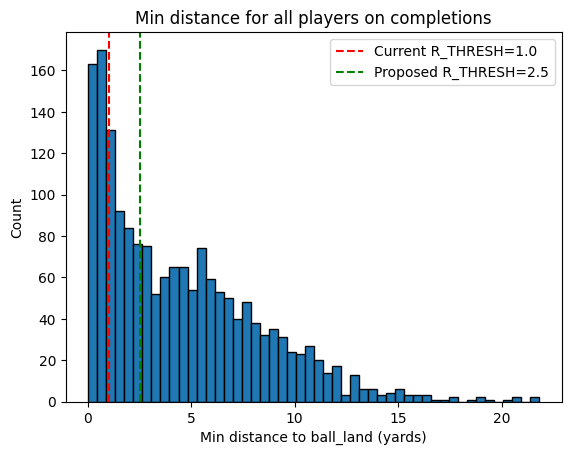

In [67]:
# Distribution of min distances for completions
completions_output = output.merge(
    model_df[model_df["pass_result"] == "C"][["game_id", "play_id"]],
    on=["game_id", "play_id"]
)

min_dists_completions = (
    completions_output
    .groupby(["game_id", "play_id", "nfl_id"])["dist_to_ball"]
    .min()
)

import matplotlib.pyplot as plt
plt.hist(min_dists_completions, bins=50, edgecolor='black')
plt.axvline(1.0, color='r', linestyle='--', label='Current R_THRESH=1.0')
plt.axvline(2.5, color='g', linestyle='--', label='Proposed R_THRESH=2.5')
plt.xlabel("Min distance to ball_land (yards)")
plt.ylabel("Count")
plt.title("Min distance for all players on completions")
plt.legend()
plt.show()

In [68]:
# Always compute min distance, regardless of arrival
min_dists = (
    output
    .groupby(["game_id", "play_id", "nfl_id"])
    .agg(min_dist=("dist_to_ball", "min"))
    .reset_index()
)

# Merge with role tags
min_dists = min_dists.merge(role_tags, on=["game_id", "play_id", "nfl_id"], how="left")

# WR min distance
wr_min_dist = (
    min_dists[min_dists["is_wr"] == 1]
    .rename(columns={"min_dist": "min_dist_WR"})
    [["game_id", "play_id", "min_dist_WR"]]
)

# Defender min distance
def_min_dist = (
    min_dists[min_dists["is_wr"] == 0]
    .groupby(["game_id", "play_id"])
    .agg(min_dist_def=("min_dist", "min"))
    .reset_index()
)

# Merge into race_emp
race_emp = race_emp.merge(wr_min_dist, on=["game_id", "play_id"], how="left")
race_emp = race_emp.merge(def_min_dist, on=["game_id", "play_id"], how="left")

# Distance-based race margin (always defined)
race_emp["deltaD_min"] = race_emp["min_dist_def"] - race_emp["min_dist_WR"]

In [69]:
feature_cols_num = [
    "deltaT_release",           # always available
    "deltaT_empirical_filled",  # fill NaN with 0
    "deltaD_min",               # always available
    "min_dist_WR",              # always available
    "min_dist_def",             # always available
    "T_WR_release",
    "T_def_min_release",
    "pass_length",
    "yards_to_go",
    "expected_points"
]

# Add missingness indicator
model_df["has_empirical_deltaT"] = model_df["deltaT_empirical"].notna().astype(int)
model_df["deltaT_empirical_filled"] = model_df["deltaT_empirical"].fillna(0.0)

feature_cols_num.append("has_empirical_deltaT")

In [70]:
# Keep only plays where targeted WR appears in output
valid_plays = wr_ids.merge(
    outputs[["game_id", "play_id", "nfl_id"]].drop_duplicates(),
    on=["game_id", "play_id", "nfl_id"],
    how="inner"
)[["game_id", "play_id"]]

model_df = model_df.merge(valid_plays, on=["game_id", "play_id"], how="inner")

model_df

,game_id,play_id,player_to_predict,nfl_id,throw_frame,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,visitor_team_win_probility_added,is_complete,T_WR_release,T_def_min_release,deltaT_release,T_WR_emp,T_def_min_emp,deltaT_empirical,has_empirical_deltaT,deltaT_empirical_filled
0,2023090700,101,True,44930,26,right,42,Josh Reynolds,6-3,196,...,-0.049720,0,2.276717,3.628350,1.351633,NaN,NaN,NaN,0,0.0
1,2023090700,194,True,41325,32,left,89,Jerick McKinnon,5-9,205,...,-0.047277,1,0.668048,1.081030,0.412982,0.2,0.6,0.4,1,0.4
2,2023090700,219,True,53591,17,left,79,Noah Gray,6-4,240,...,-0.000420,1,0.331594,1.757978,1.426384,0.1,NaN,NaN,0,0.0
3,2023090700,361,True,38696,51,right,22,Marvin Jones,6-2,198,...,-0.019525,1,5.387107,3.046986,-2.340121,NaN,NaN,NaN,0,0.0
4,2023090700,436,True,53541,20,right,31,Amon-Ra St. Brown,6-1,195,...,0.030918,1,0.896953,1.987559,1.090606,0.1,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,2023091100,3618,True,42489,31,right,48,Stefon Diggs,6-0,191,...,0.079302,1,0.693347,1.328329,0.634982,0.1,1.1,1.0,1,1.0
815,2023091100,3684,True,42489,29,right,53,Stefon Diggs,6-0,191,...,0.033010,1,0.368276,0.415346,0.047070,0.1,0.1,0.0,1,0.0
816,2023091100,3716,True,42489,18,right,68,Stefon Diggs,6-0,191,...,0.020343,1,0.844843,1.432307,0.587464,0.3,0.6,0.3,1,0.3
817,2023091100,3942,True,47879,23,left,90,Dawson Knox,6-4,254,...,-0.043432,0,0.866453,1.526747,0.660294,0.5,NaN,NaN,0,0.0


### Logistic Regression Model:

- Completion or not based on percentages
- Looking at the training vs. test